# References
1. [Langraph Documenation](https://langchain-ai.github.io/langgraph/tutorials/introduction/#requirements)
2. [Medium](https://medium.com/@kbdhunga/beginners-guide-to-langgraph-understanding-state-nodes-and-edges-part-1-897e6114fa48)


In [1]:
import os

In [4]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

from IPython.display import Image, display


# implementing a simple graph using langraph


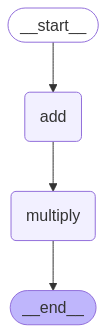

In [11]:

simple_graph_builder = StateGraph(int)

def add(state):
    print(state)
    return state+1

def multiply(state):
    print(state)
    return state*2

simple_graph_builder.add_node("add",add)
simple_graph_builder.add_node("multiply",multiply)
simple_graph_builder.add_edge(START,"add")
simple_graph_builder.add_edge("add","multiply")
simple_graph_builder.add_edge("multiply",END)

simple_graph = simple_graph_builder.compile()

display(Image(simple_graph.get_graph().draw_mermaid_png()))

In [12]:
simple_graph.invoke(1)

1
2


4

# Langraph with a State class

In [3]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

* A StateGraph object defines the structure of our chatbot as a "state machine"
* A graph whose nodes communicate by reading and writing to a shared state

In [4]:
graph_builder = StateGraph(State)

* When defining a graph, the first step is to define its State. The State includes the graph's schema and reducer functions that handle state updates. 
* In our example, State is a TypedDict with one key: messages. 
* The add_messages reducer function is used to append new messages to the list instead of overwriting it. 
* Keys without a reducer annotation will overwrite previous values.

In [ ]:
from langchain_groq import ChatGroq

llm = ChatGroq(model="llama3-70b-8192", api_key= os.getenv("GROQ_API_KEY"))


def chatbot(state: State):
    print(state)
    messages = state["messages"]
    response = llm.invoke(messages)
    return {"messages": response}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever the node is used.
graph_builder.add_node("chatbot", chatbot)

* Notice how the chatbot node function takes the current State as input and returns a dictionary containing an updated messages list under the key "messages". This is the basic pattern for all LangGraph node functions.

* The add_messages function in our State will append the llm's response messages to whatever messages are already in the state.

### Next, add an entry point. This tells our graph where to start its work each time we run it.

##### add_edge

* Adds a directed edge from the start node (or list of start nodes) to the end node.

* When a single start node is provided, the graph will wait for that node to complete before executing the end node. When multiple start nodes are provided, the graph will wait for ALL of the start nodes to complete before executing the end node.

Args:
* start_key : Union[str, list[str]]
        The key(s) of the start node(s) of the edge.
* end_key : str
        The key of the end node of the edge.


In [6]:
graph_builder.add_edge(start_key=START, end_key="chatbot")


In [7]:
graph_builder.add_edge(start_key="chatbot", end_key=END)


* Finally, we'll want to be able to run our graph. 
* To do so, call "compile()" on the graph builder. This creates a "CompiledGraph" we can use invoke on our state.

In [8]:
graph = graph_builder.compile()



* You can visualize the graph using the get_graph method and one of the "draw" methods, like draw_ascii or draw_png. The draw methods each require additional dependencies.

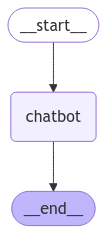

In [9]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [10]:
graph.invoke({"messages": ["Tell me about yourself"]})

{'messages': [HumanMessage(content='Tell me about yourself', additional_kwargs={}, response_metadata={}, id='4329f89e-8541-4c39-b202-cc72dfa1f976'),
  AIMessage(content="I am LLaMA, an AI assistant developed by Meta AI that can understand and respond to human input in a conversational manner. I'm a large language model trained on a massive dataset of text from the internet, which allows me to understand and respond to a wide range of topics and questions.\n\nI don't have personal experiences, emotions, or opinions like humans do. My purpose is to provide information, answer questions, and assist with tasks to the best of my abilities based on my training. I can respond in multiple languages, including English, Spanish, French, German, Italian, Portuguese, and many more.\n\nI can help with a variety of tasks, such as:\n\n* Answering questions on a wide range of topics, from science and history to entertainment and culture\n* Generating text on a given topic or subject\n* Translating tex

In [11]:
def chat(user_input:str):
    for event in graph.stream({"messages": [ {"role": "user", "content": user_input}]}):
        for value in event.values():
            print(value["messages"][-1].content)
        
while True:
    try:
        user_input = input("You: ")
        if user_input.lower() in ["exit", "quit"]:
            print("Goodbye!")
            break
        chat(user_input)
    except KeyboardInterrupt:
        print("Goodbye!")

Goodbye!


## Adding tools to the Langraph

In [68]:
from langchain_community.tools.tavily_search import TavilySearchResults

_ = os.getenv("TAVILY_API_KEY")

In [69]:
tool = TavilySearchResults(max_results=1)
tools = [tool]
# tool.invoke("What's a 'node' in LangGraph?")

In [70]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

tool_graph_builder = StateGraph(State)
llm = ChatGroq(model="llama3-70b-8192", api_key= os.getenv("GROQ_API_KEY"))

# Tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)

# defining the chatbot function:
def chatbot(state: State):
    message = state["messages"]
    response = llm_with_tools.invoke(message)
    return {"messages": response}

tool_graph_builder.add_node("chatbot", chatbot)

Next we need to create a function to actually run the tools if they are called. We'll do this by adding the tools to a new node.



In [ ]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        print(message.tool_calls)
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=tools)
tool_graph_builder.add_node("tools", tool_node)

* Conditional edges usually contain "if" statements to route to different nodes depending on the current graph state. These functions receive the current graph state and return a string or list of strings indicating which node(s) to call next.

In [ ]:
def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]

    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END

In [73]:

# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
tool_graph_builder.add_conditional_edges(
    source="chatbot",
    path = route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    path_map={"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
tool_graph_builder.add_edge("tools", "chatbot")
tool_graph_builder.add_edge(START, "chatbot")
tool_graph = tool_graph_builder.compile()

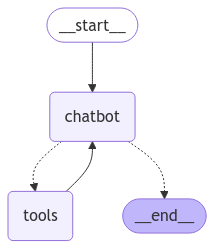

In [74]:
display(Image(tool_graph.get_graph().draw_mermaid_png()))

In [75]:
user_input = "What's a 'node' in LangGraph?"
tool_graph.invoke({"messages": [ {"role": "user", "content": user_input}]})

ai_message=AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_naz1', 'function': {'arguments': '{"query":"LangGraph node"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 49, 'prompt_tokens': 949, 'total_tokens': 998, 'completion_time': 0.18090165, 'prompt_time': 0.03646227, 'queue_time': 0.234908657, 'total_time': 0.21736392}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_2e0feca3c9', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-d63b5da0-b56c-414c-9dbc-3d2ee32a6af1-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'LangGraph node'}, 'id': 'call_naz1', 'type': 'tool_call'}], usage_metadata={'input_tokens': 949, 'output_tokens': 49, 'total_tokens': 998})
ai_message=AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ech0', 'function': {'arguments': '{"query":"LangGraph node definition"}', 'name': 'tavily_search_results_json'}, 'type'

{'messages': [HumanMessage(content="What's a 'node' in LangGraph?", additional_kwargs={}, response_metadata={}, id='70645dee-ec29-404f-a044-d8605480c2fb'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_naz1', 'function': {'arguments': '{"query":"LangGraph node"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 49, 'prompt_tokens': 949, 'total_tokens': 998, 'completion_time': 0.18090165, 'prompt_time': 0.03646227, 'queue_time': 0.234908657, 'total_time': 0.21736392}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_2e0feca3c9', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-d63b5da0-b56c-414c-9dbc-3d2ee32a6af1-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'LangGraph node'}, 'id': 'call_naz1', 'type': 'tool_call'}], usage_metadata={'input_tokens': 949, 'output_tokens': 49, 'total_tokens': 998}),
  ToolMessage(content='[{"url": "https://blog.langc

In [78]:
def stream_graph_updates(user_input: str):
    for event in tool_graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value)

user_input = "Who is the prime minister of India?"
stream_graph_updates(user_input)

ai_message=AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_hg4p', 'function': {'arguments': '{"query":"Who is the prime minister of India"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 53, 'prompt_tokens': 947, 'total_tokens': 1000, 'completion_time': 0.171517849, 'prompt_time': 0.036281817, 'queue_time': 0.245789568, 'total_time': 0.207799666}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_2e0feca3c9', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-d826cf9f-5771-4f5a-ab1d-d7a79bcaa0dc-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Who is the prime minister of India'}, 'id': 'call_hg4p', 'type': 'tool_call'}], usage_metadata={'input_tokens': 947, 'output_tokens': 53, 'total_tokens': 1000})
Assistant: {'messages': AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_hg4p', 'function': {'arguments': '{"query":"Who is the prime 

In [81]:
from langgraph.prebuilt import ToolNode, tools_condition

class State(TypedDict):
    messages: Annotated[list, add_messages]

simple_tool_graph_builder = StateGraph(State)

tool = TavilySearchResults(max_results=1)
tools = [tool]
llm = ChatGroq(model="llama3-70b-8192", api_key= os.getenv("GROQ_API_KEY"))
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    message = state["messages"]
    response = llm_with_tools.invoke(message)
    return {"messages": response}

simple_tool_graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
simple_tool_graph_builder.add_node("tools", tool_node)

simple_tool_graph_builder.add_conditional_edges(
    source="chatbot",
    path = tools_condition,
    path_map={"tools": "tools", END: END},
)

simple_tool_graph_builder.add_edge("tools", "chatbot")
simple_tool_graph_builder.add_edge(START, "chatbot")
simple_tool_graph = simple_tool_graph_builder.compile()

In [83]:
simple_tool_graph.invoke({"messages": [ {"role": "user", "content": "Tell me about yourself"}]})


{'messages': [HumanMessage(content='Tell me about yourself', additional_kwargs={}, response_metadata={}, id='496bdc70-a9c3-4a63-b657-364f1993594c'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_h974', 'function': {'arguments': '{"query":"information about myself"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 49, 'prompt_tokens': 943, 'total_tokens': 992, 'completion_time': 0.162150408, 'prompt_time': 0.0367299, 'queue_time': 0.23897015199999996, 'total_time': 0.198880308}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_2e0feca3c9', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-6ad050cf-9d81-451d-90b8-f5577d45cfc3-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'information about myself'}, 'id': 'call_h974', 'type': 'tool_call'}], usage_metadata={'input_tokens': 943, 'output_tokens': 49, 'total_tokens': 992}),
  ToolMessage(content='[{"url

## Simple Tool Call Graph

In [139]:
from langgraph.graph import MessageGraph
def ulfa(first: int, second: int):
    """Adds two numbers"""
    return first * second

def do_yoyo(first: int, second: int):
    """Multiplies two numbers"""
    return first + second

tools = [ulfa, do_yoyo]

model = ChatGroq(model="llama-3.3-70b-versatile", api_key= os.getenv("GROQ_API_KEY"))
model_with_tools = model.bind_tools(tools)

simple_tool_graph_builder = MessageGraph()

simple_tool_graph_builder.add_node("model", model_with_tools)

action_node = ToolNode(tools=tools)
simple_tool_graph_builder.add_node("action", action_node)

simple_tool_graph_builder.set_entry_point("model")
simple_tool_graph_builder.add_edge("action", END)

def router(state):
    last_message = state[-1]
    if hasattr(last_message, "tool_calls"):
        return "action"
    else:
      return END

simple_tool_graph_builder.add_conditional_edges(
    source="model",
    path = router,
)


simple_tool_graph = simple_tool_graph_builder.compile()

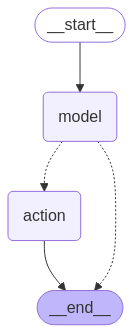

In [143]:
display(Image(simple_tool_graph.get_graph().draw_mermaid_png()))

## Based on the question asked, the LLM will decide if it needs to use the tools it has at it's disposal. 
* How does the LLM know which tool to use? It will decide based on the description of the tools, doc strings if we are writing custom tools using our own functions
* Here we have supplied two tool, ulfa, do_yoyo, the description of ulfa is "add two numbers" but it does multiplication. When we ask the LLM to add two numbers, it will use the tool ulfa based on the description of the tool ulfa. But as the function ulfa multiplies numbers, we get a response of multipliation:
q = 100 + 52
answer = 5200

Hence it is important to give the right description for the functions and use appropriate names for the functions that are being used as tools. 

In [141]:
simple_tool_graph.invoke("What is 100+52")

[HumanMessage(content='What is 100+52', additional_kwargs={}, response_metadata={}, id='09514aa1-1e44-4ae0-a5ea-73fcf408601b'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_jzkj', 'function': {'arguments': '{"first":100,"second":52}', 'name': 'ulfa'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 277, 'total_tokens': 294, 'completion_time': 0.061818182, 'prompt_time': 0.02170253, 'queue_time': 0.223848274, 'total_time': 0.083520712}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_2ca0059abb', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-8126289f-c9be-4958-ae5e-c409d81cb72a-0', tool_calls=[{'name': 'ulfa', 'args': {'first': 100, 'second': 52}, 'id': 'call_jzkj', 'type': 'tool_call'}], usage_metadata={'input_tokens': 277, 'output_tokens': 17, 'total_tokens': 294}),
 ToolMessage(content='5200', name='ulfa', id='85557ad3-2c59-4233-aaa5-d34fb126bce9', tool_call_id='call_jzkj')]

## In the below question the tools are not used, the answer is straight from the LLM's knowledge

In [142]:
simple_tool_graph.invoke("who is the prime minister of India?")

[HumanMessage(content='who is the prime minister of India?', additional_kwargs={}, response_metadata={}, id='d3993263-300f-44ff-a7b8-d0df80cbfad2'),
 AIMessage(content='I\'m not aware of the current Prime Minister of India. For the most up-to-date information, I recommend checking a reliable news source or the official website of the Government of India.\n\nIf you want to perform a search for this information, I can suggest searching for "Current Prime Minister of India" or "Prime Minister of India" along with the current year to get the latest information.\n\nHowever, I don\'t have any specific information about the current Prime Minister of India, and I don\'t want to provide outdated or incorrect information. It\'s always best to verify information from a reliable source.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 120, 'prompt_tokens': 279, 'total_tokens': 399, 'completion_time': 0.436363636, 'prompt_time': 0.015254778, 'queue_time': 0.223601567,